# Lab04 - SAT solving in Python with Z3

# Example (long conjunctions and disjunctions)

In [1]:
from z3 import *

n = 10
x = [Bool('x' + str(k)) for k in range(n)]
phi = And([x[k] for k in range(n)])
print(phi)

solve(phi) # satisfiable

And(x0, x1, x2, x3, x4, x5, x6, x7, x8, x9)
[x2 = True,
 x1 = True,
 x0 = True,
 x3 = True,
 x7 = True,
 x9 = True,
 x4 = True,
 x5 = True,
 x6 = True,
 x8 = True]


# Exercise (The SCS problem)

Let $\Sigma = \{0, 1\}$ be a finite alphabet. The *shortest common superstring* problem (SCS) has as input a set of finite strings $S = \{w_1, \dots, w_m\}$ with $w_i \in \Sigma^*$ and asks for the smallest n such that there exists a string $w \in \Sigma^n$ of length $n$ s.t. $w$ is a (contiguous) superstring  of $w_1, \dots, w_m
$. The SCS problem is NP-complete. As there is a trivial upper bound - sum of lengths of strings in S - the most important question is the decision problem whether such a superstring $w \in \Sigma^n$ of length $n$ exists for a given $n$, further referred to as CS(n).

1. Encode the CS(n) problem as a SAT problem and use Z3 to solve it.
2. Find the smallest n using a binary search algorithm.

In [2]:
from z3 import *

# input example
S = ["001010011101", "1001010101011", "101101010101010",
     "10111011001010101010", "10110101011010101010", "10110101101010101010"]
m = len(S)
maxn = sum(map(len, S))

# how to declare a list of n variables x0, ..., x(n-1)
x = [ Bool('x' + str(k)) for k in range(maxn) ]

# this procedure returns an assignment (as a dictionary) if any exists
def model(phi):
    # create a SAT instance
    s = Solver()
    s.add(phi)
    # return a satisfying assignment
    return s.model() if s.check() == sat else {}

def cs(n):
    if n == maxn: # it is so simple for n == maxn only :)
        s = "".join(S)
        phi = And([x[k] if s[k]=="1" else Not(x[k]) for k in range(len(s))])
        return model(phi)
    else:
        clauses = []
        for w in S:
            clause = Or([And([x[i+j] if w[j]=="1" else Not(x[i+j]) for j in range(len(w))]) for i in range(n - len(w) + 1)])
            clauses.append(clause)
        phi = And(clauses)
        return model(phi)

def binsearch():
    l, r = 0, maxn
    while l < r:
        mid = (l + r) // 2
        solution = cs(mid)
        if solution:
            r = mid
        else:
            l = mid + 1
    return l
    
solution = cs(maxn)
print([(var, solution[var]) for var in x[:maxn]]) # not very interesting to see :)
w = "".join(("1" if solution[var] else "0" for var in x[:maxn]))
print("Solution:", w)
print("Check: ", [(w_i in w) for w_i in S])

smallest_n = binsearch()
print("Smallest n:", smallest_n)

[(x0, False), (x1, False), (x2, True), (x3, False), (x4, True), (x5, False), (x6, False), (x7, True), (x8, True), (x9, True), (x10, False), (x11, True), (x12, True), (x13, False), (x14, False), (x15, True), (x16, False), (x17, True), (x18, False), (x19, True), (x20, False), (x21, True), (x22, False), (x23, True), (x24, True), (x25, True), (x26, False), (x27, True), (x28, True), (x29, False), (x30, True), (x31, False), (x32, True), (x33, False), (x34, True), (x35, False), (x36, True), (x37, False), (x38, True), (x39, False), (x40, True), (x41, False), (x42, True), (x43, True), (x44, True), (x45, False), (x46, True), (x47, True), (x48, False), (x49, False), (x50, True), (x51, False), (x52, True), (x53, False), (x54, True), (x55, False), (x56, True), (x57, False), (x58, True), (x59, False), (x60, True), (x61, False), (x62, True), (x63, True), (x64, False), (x65, True), (x66, False), (x67, True), (x68, False), (x69, True), (x70, True), (x71, False), (x72, True), (x73, False), (x74, True), 

# Exercise (Phase transition)

In this exercise we explore the phenomenon of *phase transition* for the $k$-SAT problem, where $k$ is the size of each clause. Let $n$ be the number of variables $X = \{x_1, \dots, x_n\}$ and let $m$ be the number of clauses. A random $k$-SAT instance is obtained by producing each of the $m$ clauses according to the following process:

* Extract $k$ variables without replacement from $X$ and determine independently and uniformly whether each variable appears positively or negatively.

Fix $k = 3$, $n = 10$, and let $p_{m/n}$ be the probability that a SAT instance randomly generated as above is satisfiable.

1. For a fixed $m$, compute an estimate $\hat p_{m / n}$ by sampling $N = 100$ instances as above.
2. Plot the estimates $\hat p_{m / n}$ as a function of $m \in \{1, \dots, 10 \cdot n \}$.
3. What is an "interesting" interval for $m$? Refine the interval above if necessary.

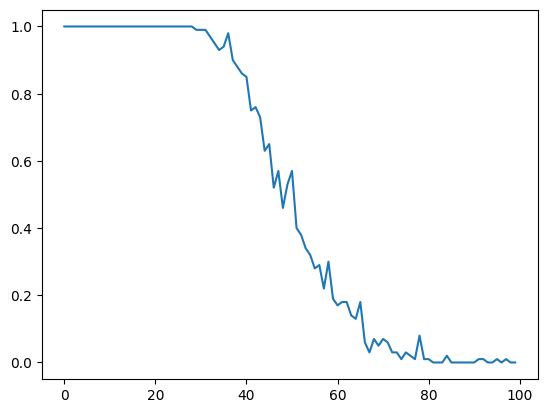

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random

# number of variables
n = 10

# size of a clause
k = 3

# number of samples per point
N = 100

variables = [Bool('x' + str(i)) for i in range(n)]

# Hints:
# np.random.choice(list) returns a random element from list
# np.random.choice(list, k, replace=False) returns k random elements from list *without replacement*
# np.mean(list) computes the average of the numbers in the list
# plt.plot(list) generates a plot from a list of values
# plt.show() displays the plot

def sample(m):
    clauses = []
    for _ in range(m):
        clause = []
        for var in np.random.choice(variables, k, replace=False):
            if random.random() < 0.5:
                clause.append(var)
            else:
                clause.append(Not(var))
        clauses.append(Or(clause))
    return And(clauses)

def is_satisfiable(phi):
    s = Solver()
    s.add(phi)
    return s.check() == sat

def estimate_probability(m):
    satisfiable_count = 0
    for _ in range(N):
        if is_satisfiable(sample(m)):
            satisfiable_count += 1
    return satisfiable_count / N

list = [estimate_probability(m) for m in range(1, 10 * n + 1)]
plt.plot(list)
plt.show()